## Mount drive to access data files

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing library


In [74]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.cluster import KMeans
import dask.dataframe as dd

## data paths

In [75]:
train_path = '/content/drive/MyDrive/Structured_Data_Assignment/Structured_Data_Assignment/train.parquet'
test_path = '/content/drive/MyDrive/Structured_Data_Assignment/Structured_Data_Assignment/test.parquet'

## Load the train data


In [76]:
data= pd.read_parquet(train_path)

In [77]:
data

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220868 entries, 0 to 29080911
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Patient-Uid  object        
 1   Date         datetime64[ns]
 2   Incident     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 98.3+ MB


In [ ]:
target_drug_data = data[data['Incident'] == 'TARGET DRUG']

<ipython-input-79-f1aceda59b68>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_drug_data['Date'] = pd.to_datetime(target_drug_data['Date'])
<ipython-input-79-f1aceda59b68>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_drug_data['YearMonth'] = target_drug_data['Date'].dt.to_period('M')


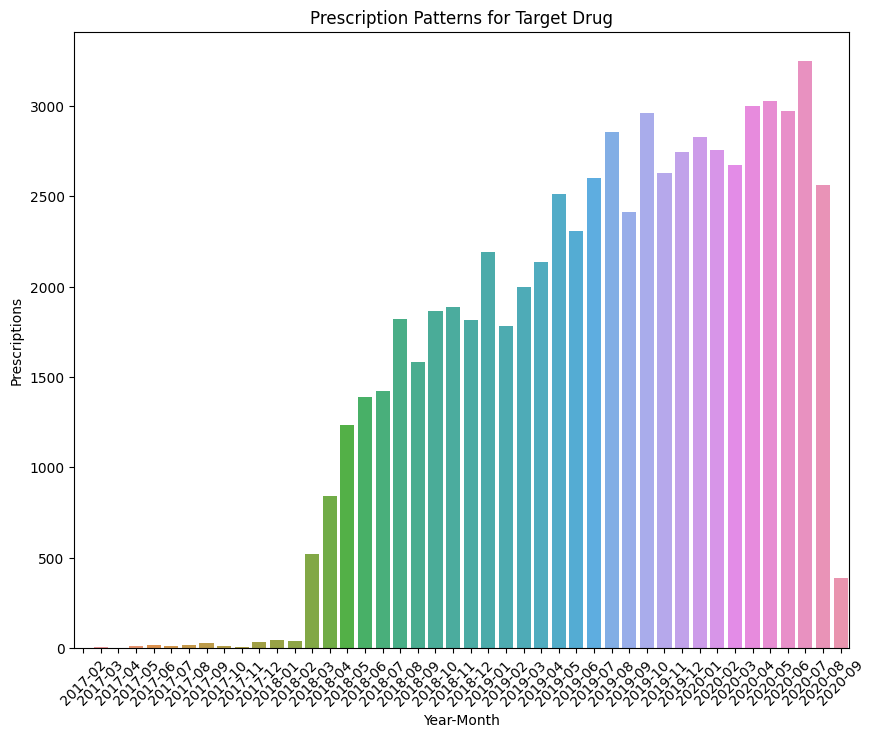

In [79]:
target_drug_data['Date'] = pd.to_datetime(target_drug_data['Date'])
target_drug_data['YearMonth'] = target_drug_data['Date'].dt.to_period('M')
prescription_counts = target_drug_data['YearMonth'].value_counts().sort_index().reset_index()
prescription_counts.columns = ['YearMonth', 'Prescriptions']
plt.figure(figsize=(10, 8))
sns.barplot(data=prescription_counts, x='YearMonth', y='Prescriptions')
plt.xlabel('Year-Month')
plt.ylabel('Prescriptions')
plt.title('Prescription Patterns for Target Drug')
plt.xticks(rotation=45)
plt.show()

In [101]:
# Convert 'Date' column to datetime format
target_drug_data.loc[:, 'Date'] = pd.to_datetime(target_drug_data['Date'])
# Calculate prescription intervals, handling missing values
target_drug_data['PrescriptionInterval'] = target_drug_data.groupby('Patient-Uid')['Date'].diff().dt.days
target_drug_data['PrescriptionInterval'].fillna(target_drug_data['PrescriptionInterval'].median(), inplace=True)

<ipython-input-101-769194d41440>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  target_drug_data.loc[:, 'Date'] = pd.to_datetime(target_drug_data['Date'])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

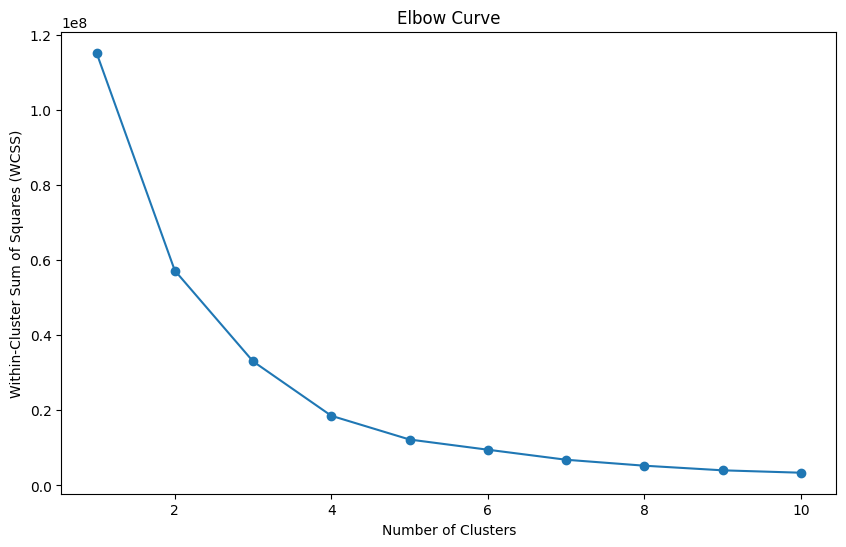

In [100]:
X = target_drug_data[['PrescriptionInterval']].values
wcss = [] 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Curve')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


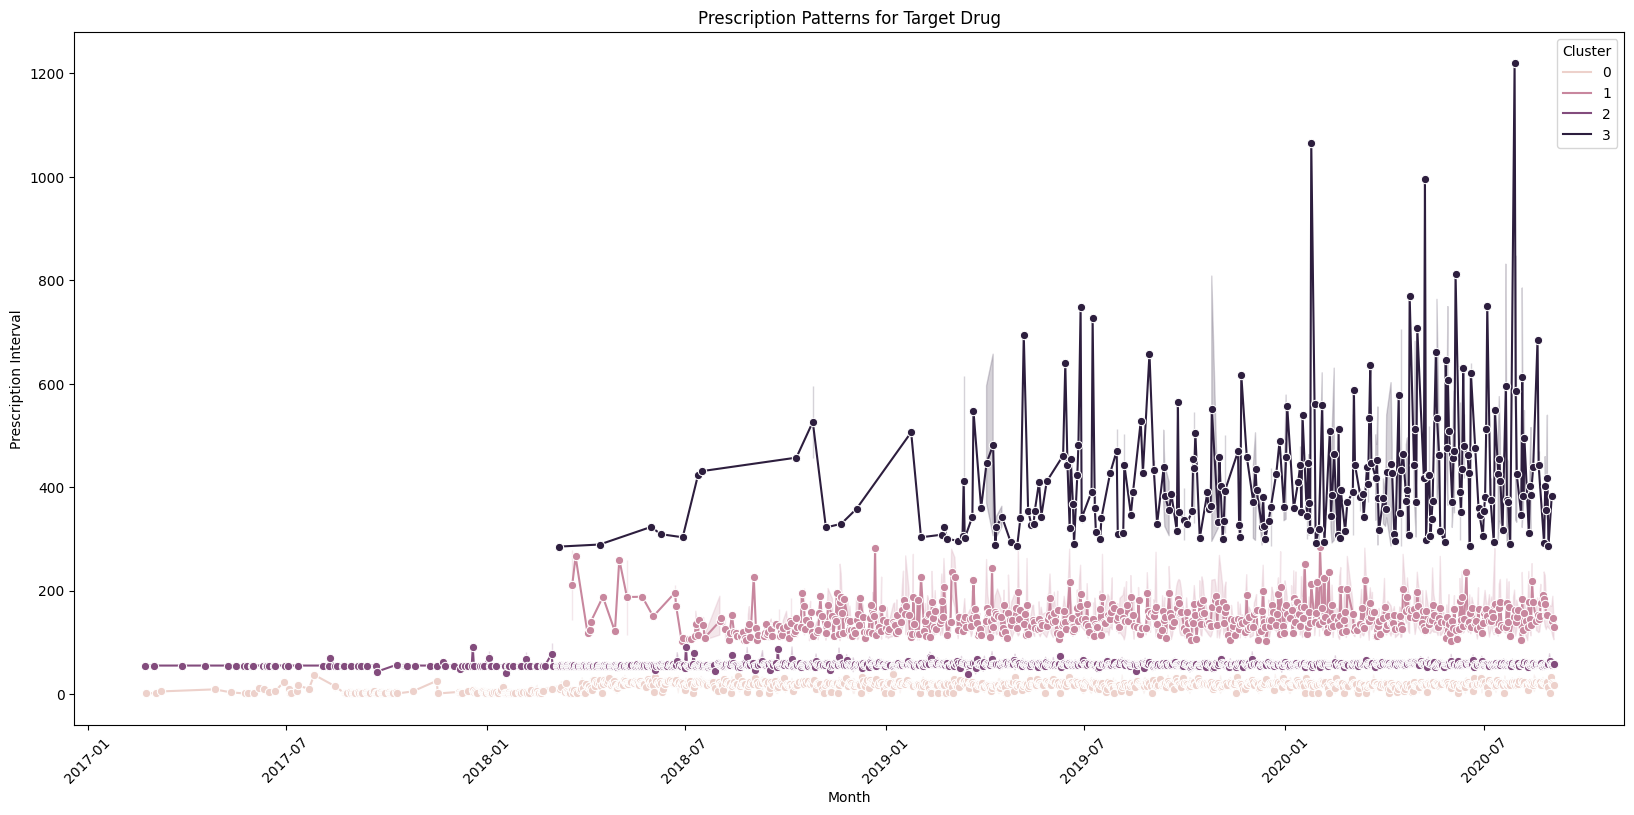

In [103]:
num_clusters = 4 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
target_drug_data['Cluster'] = kmeans.fit_predict(X)
cluster_patterns = target_drug_data.groupby('Cluster').agg({'PrescriptionInterval': 'mean', 'Patient-Uid': 'count'}).reset_index()
cluster_patterns.columns = ['Cluster', 'AverageInterval', 'PrescriptionCount']
plt.figure(figsize=(20, 9))
sns.lineplot(data=target_drug_data, x='Date', y='PrescriptionInterval', hue='Cluster', marker='o')
plt.xlabel('Month')
plt.ylabel('Prescription Interval')
plt.title('Prescription Patterns for Target Drug')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()